In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the dataset
transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),  # Resize the image to 28x28
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,)),  # Normalize images
    ]
)

# Download and load the training and test datasets
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

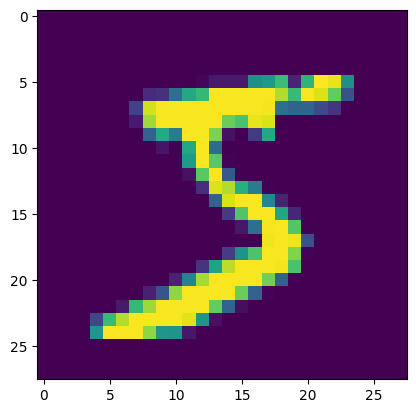

In [2]:
def imshow(img):
    npimg = img[0].numpy() if isinstance(img, tuple) else img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


imshow(train_dataset[0])

In [3]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

In [4]:
model = NeuralNet()

In [5]:
import time
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  
    
    model.to(device)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()  # Start timing epoch
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        for i, (images, labels) in progress_bar:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (i + 1) % 100 == 0:  
                progress_bar.set_postfix(current_loss=loss.item())
                running_loss = 0.0
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1}/{num_epochs} completed in {epoch_time // 60:.0f} minutes and {epoch_time % 60:.0f} seconds")
        
        # Optionally save the model checkpoint
        torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")


In [6]:
def evaluate_model(model, test_loader):
    model.eval()  # turn train mode OFF

    total = 0
    correct = 0

    with torch.no_grad():  # No need to compute gradients
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

In [7]:
train_model(
    model, train_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.001), num_epochs=5
)

Epoch 1/5: 100%|██████████| 1875/1875 [00:36<00:00, 50.68it/s, current_loss=0.055]


Epoch 1/5 completed in 0 minutes and 37 seconds


Epoch 2/5: 100%|██████████| 1875/1875 [00:42<00:00, 44.21it/s, current_loss=0.199] 


Epoch 2/5 completed in 0 minutes and 42 seconds


Epoch 3/5: 100%|██████████| 1875/1875 [00:34<00:00, 54.76it/s, current_loss=0.0777] 


Epoch 3/5 completed in 0 minutes and 34 seconds


Epoch 4/5: 100%|██████████| 1875/1875 [00:32<00:00, 58.58it/s, current_loss=0.0737]


Epoch 4/5 completed in 0 minutes and 32 seconds


Epoch 5/5: 100%|██████████| 1875/1875 [00:30<00:00, 60.73it/s, current_loss=0.0248]

Epoch 5/5 completed in 0 minutes and 31 seconds


In [8]:
evaluate_model(model, test_loader)

Evaluating: 100%|██████████| 313/313 [00:04<00:00, 73.56it/s]

Accuracy: 96.80%


In [9]:
def display_model_predictions(model, test_loader, num_images=5):
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    rows = int(np.ceil(num_images / 5))
    columns = 5
    fig, axes = plt.subplots(rows, columns, figsize=(12, 6))
    for i in range(rows * columns):
        if i < num_images:
            current_row = i // 5
            image = images[i] / 2 + 0.5  # Unnormalize
            if rows > 1:
                axes[current_row, i % 5].imshow(image.permute(1, 2, 0).numpy())
                axes[current_row, i % 5].set_title(f"Label: {labels[i]}, Predicted: {predicted[i]}")
                axes[current_row, i % 5].axis("off")
            else:
                axes[i].imshow(image.permute(1, 2, 0).numpy())
                axes[i].set_title(f"Label: {labels[i]}, Predicted: {predicted[i]}")
                axes[i].axis("off")
        else:
            if rows > 1:
                axes[current_row, i % 5].axis("off")
            else:
                axes[i].axis("off")
    plt.tight_layout()
    plt.show()

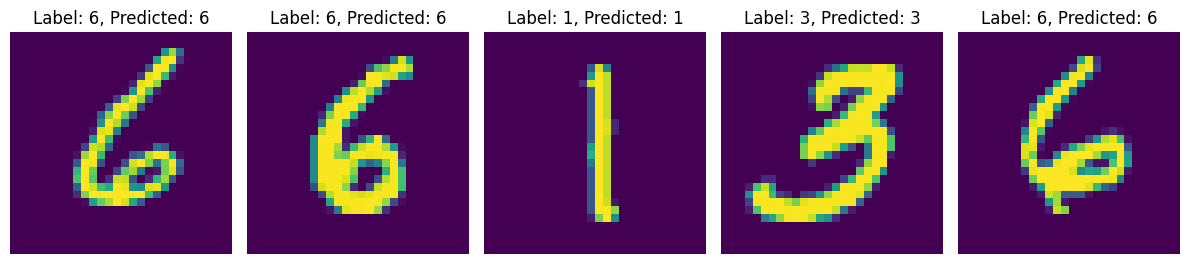

In [10]:
display_model_predictions(model, test_loader, num_images=5)

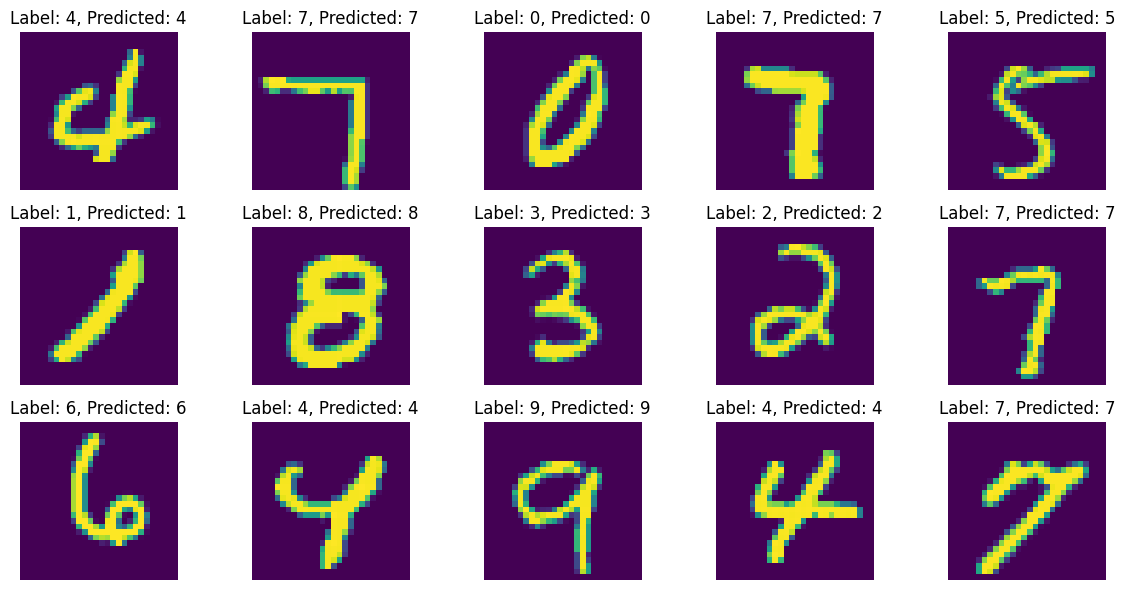

In [11]:
display_model_predictions(model, test_loader, num_images=15)

In [12]:
from torchsummary import summary


summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------
